## Hypertune timegan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from models.data_generating_models.time_gan import TimeGAN
from data_processing.post_processing import post_processing
from data_processing.config import post_processing_config
from models.DeepHedger import hedging
from config import data_generation_config
import wandb

## Load data

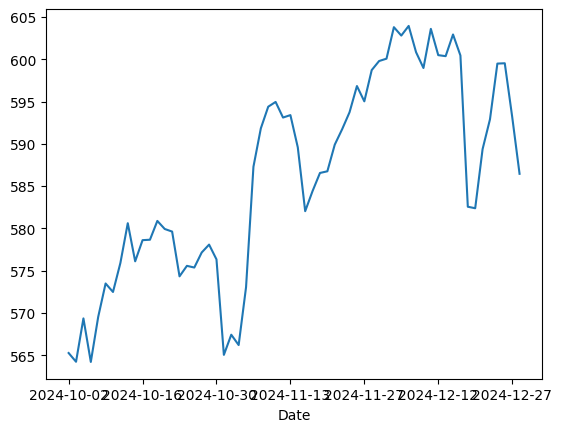

In [2]:
train_data = pd.read_csv("../data/raw/spy_daily_closing_prices_train.csv", index_col=0)

val_data = pd.read_csv("../data/raw/spy_daily_closing_prices_val.csv", index_col=0)

val_data = val_data["Close"]
val_data.plot(use_index=True)
val_data = np.array([val_data.values[i:i+30] for i in range(len(val_data)-30 + 1)])
val_data = pd.DataFrame(val_data)
val_data = val_data.div(val_data.iloc[:, 0], axis=0)

test_data = pd.read_csv("../data/raw/spy_daily_closing_prices_test.csv", index_col=0)
test_data = test_data["Close"]
test_data = np.array([test_data.values[i:i+30] for i in range(len(test_data)-30 + 1)])
test_data = pd.DataFrame(test_data)
test_data = test_data.div(test_data.iloc[:, 0], axis=0)

In [ ]:
wandb.login(key="52ea61320bbc9ee2b773e909700366e65977cd0f")

In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'noise_scale': {
            'distribution': 'uniform',
            'min': 0.01,
            'max': 0.15
        },
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.001,
            'max': 0.1
        },
        'hidden_size': {
            'values': [4, 8, 16, 32]
        },
    }
}

time_gan_config = {
    "data_name": "master",
    "module": "gru",
    "hidden_dim": 24,
    "num_layer": 3,
    "iterations": 10000,
    "batch_size": 128,
    "seq_len": 24,
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="time_gan_hyperopt")
# sweep_id = ""

In [3]:
def objective(config):
    hyperparameters = {
            "data_name": "master",
            "module": "gru",
            "hidden_dim": config.hidden_dim,
            "num_layer": config.num_layer,
            "iterations": 10000,
            "batch_size": 128,
            "seq_len": 24,
        }
    
    model = TimeGAN(train_data=train_data, N=data_generation_config["N"], M=data_generation_config["M"], load_params=False, config=hyperparameters)
    
    print("Fitting params to data")
    model.fit_params_to_data()
    print("Generating data")
    model.generate_data()

    df_post_processed = post_processing(model.synth_data, **post_processing_config)

    print('Hedging')
    val_loss = hedging(df_post_processed, val_data)

    return val_loss

def main():
    wandb.init()
    val_loss = objective(wandb.config)
    wandb.log({"val_loss": val_loss,  "loss": val_loss})

In [ ]:
wandb.agent(sweep_id, function=main, count=10, project="time_gan_hyperopt")

## Testing and plotting

In [9]:
hyperparameters = {
            "data_name": "master",
            "module": "gru",
            "hidden_dim": 16,
            "num_layer": 3,
            "iterations": 3000, # 10000,
            "batch_size": 32,
            "seq_len": 30,
        }
    
model = TimeGAN(train_data=train_data, N=data_generation_config["N"], M=data_generation_config["M"], load_params=False, config=hyperparameters)

print("Training and generating data")
model.generate_data()
# print("Generating data")
# model.generate_data()

df_post_processed = post_processing(model.synth_data, **post_processing_config)


# print('Hedging')
# val_loss = hedging(df_post_processed, val_data)

Training and generating data
step: 0/3000, e_loss: 0.1711
step: 1000/3000, e_loss: 0.0048
step: 2000/3000, e_loss: 0.0084
step: 0/3000, s_loss: 0.0871
step: 1000/3000, s_loss: 0.0033
step: 2000/3000, s_loss: 0.0023
step: 0/3000, d_loss: 1.8669, g_loss_u: 0.7232, g_loss_s: 0.0133, g_loss_v: 0.2699, e_loss_t0: 0.0713
step: 1000/3000, d_loss: 0.1502, g_loss_u: 3.1261, g_loss_s: 0.0011, g_loss_v: 0.1591, e_loss_t0: 0.0014
step: 2000/3000, d_loss: 0.15, g_loss_u: 3.1912, g_loss_s: 0.0021, g_loss_v: 0.2092, e_loss_t0: 0.0053
Generating data


/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


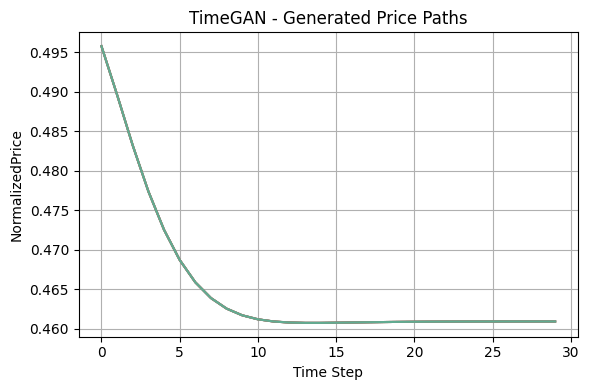

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

# Plot post-processed paths
for i in range(10):
    axs.plot(model.synth_data.iloc[i, :], alpha=0.5)


axs.set_title('TimeGAN - Generated Price Paths')
axs.set_xlabel('Time Step')
axs.set_ylabel('NormalizedPrice')
axs.grid(True)

plt.tight_layout()
plt.show()

In [7]:
from visualisation import visualization

train_data_vis = np.array(train_data[["Close"]].values)
train_data_vis = np.array([train_data_vis[i:i+30] for i in range(len(train_data_vis)-30 + 1)])
train_data_vis = train_data_vis / train_data_vis[:, 0:1]

df_post_processed_vis = np.array(df_post_processed.values)
df_post_processed_vis = df_post_processed_vis[..., np.newaxis]

print(train_data_vis.shape)
print(df_post_processed_vis.shape)

# visualization(ori_data=train_data_vis, generated_data=df_post_processed_vis, analysis='tsen', data_generating_model="TimeGAN", compare=train_data_vis.shape[0])
visualization(ori_data=train_data_vis, generated_data=df_post_processed_vis, analysis='tsne', data_generating_model="TimeGAN", compare=1000)

(1060, 30, 1)
(1059, 30, 1)


/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ValueError: Input X contains infinity or a value too large for dtype('float64').